In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets

# 1. Configuración de los Widgets
alfa_input     = widgets.FloatText(min=1,          step=0.1, value=5.0, layout=widgets.Layout(width='140px'), description='alfa %:', )
n_input        = widgets.IntText(min=40,  max=150, step=1,   value=60,  layout=widgets.Layout(width='130px'), description='máximo n:')
n_intervalo    = widgets.FloatText(min=1, max=10,  step=0.1, value=5.0, layout=widgets.Layout(width='130px'), description='veloc. (1-10):')
pct_diff_z_t   = widgets.FloatText(min=1, max=10,  step=0.1, value=4.3, layout=widgets.Layout(width='130px'), description='% diff Z y t :')

# Después modificar el valor de uno omás  parametros o widgets se debe presionar Actualizar Gráfico
btn_render = widgets.Button(description="Actualizar Gráfico", button_style='success', icon='play')
output = widgets.Output()

def simulacion_t_dinamica(b=None):
    btn_render.description = "Procesando..."
    btn_render.disabled = True
    output.clear_output(wait=True)

    with output:
        alfa_pct = alfa_input.value
        n_muestral = n_input.value
        n_interv = n_intervalo.value
        p_tolerancia = pct_diff_z_t.value/100

        ms_intervalo = int(436.67 - (n_interv * 36.67))
        alfa_dec = alfa_pct / 100
        q_critica = 1 - (alfa_dec / 2)
        pct_confianza = 100 - alfa_pct

        fig, ax = plt.subplots(figsize=(9, 5))
        x = np.linspace(-5, 5, 400)
        z_crit = norm.ppf(q_critica)

        ax.plot(x, norm.pdf(x), 'k--', lw=1.5, alpha=0.2, label='Normal (Ref.)')
        ax.axvline(z_crit, color='green', linestyle='--', alpha=0.3)
        ax.axvline(-z_crit, color='green', linestyle='--', alpha=0.3)

        line, = ax.plot([], [], lw=2.5)
        v_line_pos = ax.axvline(0, color='red', linestyle=':', alpha=0.6)
        v_line_neg = ax.axvline(0, color='red', linestyle=':', alpha=0.6)

        # Inicialización de objetos de texto (una sola vez)
        text_t = ax.text(0.02, 0.82, '', transform=ax.transAxes, fontsize=9, family='monospace', bbox=dict(facecolor='white', alpha=0.8))
        text_z = ax.text(0.98, 0.82, '', transform=ax.transAxes, fontsize=9, ha='right', family='monospace', bbox=dict(facecolor='#f8f9fa', alpha=0.8))
        text_conv = ax.text(0, 0.12, '', ha='center', fontsize=10, color='darkgreen', fontweight='bold')
        ax.text(0, 0.05, f'Confianza: {pct_confianza:,.2f}%', ha='center', fontsize=12, fontweight='bold')

        ax.set_ylim(0, 0.45)
        ax.set_xlim(-5, 5)
        ax.set_title(f'Convergencia t-Student hacia Normal Z (α = {alfa_pct}%)', pad=20)

        frames_expandidos = []
        for n in range(2, n_muestral + 1):
            frames_expandidos.append(n)
            if 25 < n < 35: frames_expandidos.extend([n] * 4)

        # Variable para controlar la detección del n crítico en cada renderizado
        contexto = {'n_critico': None}

        def update(n):
            gl = n - 1
            y_t = t.pdf(x, gl)
            t_crit = t.ppf(q_critica, gl)
            dif = t_crit - z_crit
            dif_relativa = abs(dif) / z_crit

            if dif_relativa <= p_tolerancia:
                color = '#2ecc71'
                if contexto['n_critico'] is None:
                    contexto['n_critico'] = n
                text_conv.set_text(f'¡Convergencia alcanzada!\n \n n crítico: {contexto["n_critico"]} (dif < {p_tolerancia*100:.1f}%)')
            else:
                color = '#e74c3c'
                text_conv.set_text('')

            line.set_data(x, y_t)
            line.set_color(color)
            v_line_pos.set_xdata([t_crit, t_crit])
            v_line_neg.set_xdata([-t_crit, -t_crit])
            v_line_pos.set_color(color)
            v_line_neg.set_color(color)

            text_t.set_text(f"DISTRIBUCIÓN t\nn  = {n}\nGL = {gl}\nt-crítico = ±{t_crit:.3f}")
            text_z.set_text(f"REFERENCIA Z\nα = {alfa_pct:.1f}%\nz-crítico = ±{z_crit:.3f}\nDiferencia = {dif:.3f}")

            while len(ax.collections) > 0:
                ax.collections[-1].remove()

            ax.fill_between(x, 0, y_t, where=(np.abs(x) <= t_crit), color=color, alpha=0.1)
            ax.fill_between(x, 0, y_t, where=(np.abs(x) > t_crit), color=color, alpha=0.4)

            return line, v_line_pos, v_line_neg, text_t, text_z, text_conv

        ani = FuncAnimation(fig, update, frames=frames_expandidos, interval=ms_intervalo, repeat=False, blit=False)
        plt.close(fig)
        display(HTML(ani.to_jshtml()))

    btn_render.description = "Actualizar Gráfico"
    btn_render.disabled = False

btn_render.on_click(simulacion_t_dinamica)
display(widgets.VBox([widgets.HBox([alfa_input, n_input, n_intervalo,pct_diff_z_t, btn_render]), output]))
simulacion_t_dinamica()


### Análisis de la Regla de $n > 30$ y la Convergencia

La regla de que **$n > 30$** es una muestra "suficientemente grande" es una regla empírica (heurística) generalizada, pero no es una verdad matemática absoluta ni depende exclusivamente del **$\alpha = 5\%$**.

En realidad, la validez de esta regla depende de dos factores que el código ilustra muy bien:

#### 1. No es por el $\alpha$, es por la forma de la distribución
La distribución **$t$-Student** tiene "colas" más pesadas que la Normal. A medida que $n$ aumenta, los grados de libertad ($gl = n - 1$) crecen y la forma de la curva $t$ se vuelve indistinguible de la Normal $Z$.
* Para la mayoría de los propósitos prácticos (ingeniería, ciencias sociales), a partir de **$n = 30$**, la diferencia en la densidad de probabilidad central es mínima.
* Sin embargo, el valor crítico ($t_{crit}$) sigue siendo distinto al de $Z$ incluso para **$n = 30$**.

#### 2. El efecto del $\alpha$ en la convergencia
El valor de $\alpha$ determina qué tan lejos en las "colas" de la distribución estamos mirando. Aquí es donde la regla de 30 puede fallar:
* **Con $\alpha = 5\%$:** El $z_{crit}$ es $\pm 1.96$. Para $n = 30$ ($gl = 29$), el $t_{crit}$ es $\pm 2.045$. La diferencia es pequeña ($\approx 0.08$).
* **Con $\alpha = 1\%$:** El $z_{crit}$ es $\pm 2.576$. Para $n = 30$, el $t_{crit}$ es $\pm 2.756$. La diferencia es mayor ($\approx 0.18$).
* **Con $\alpha$ muy pequeños (ej. $0.1\%$):** Las colas de la $t$-Student tardan mucho más en "adelgazar" hasta alcanzar a la Normal. Aquí podrías necesitar un $n > 100$ para que la aproximación sea buena.

#### 3. El factor más importante: La población original
La regla de **$n > 30$** nace principalmente del **Teorema del Límite Central (TLC)**.
* Si la población de donde se saca la muestra **ya es normal**, se puede usar la distribución Normal incluso con $n = 2$ (si se conoce $\sigma$).
* Si la población es **muy asimétrica** (tiene sesgo) o tiene valores atípicos extremos, un $n = 30$ no será suficiente para que la distribución de la media sea normal; se podría necesitar $n = 50$ o $n = 100$.

---

### Resumen Técnico
La regla de 30 se usa porque para un $\alpha$ estándar (0.05) y una población con asimetría moderada, el error que se comete al usar $Z$ en lugar de $t$ suele ser menor al **5% relativo**, lo cual es aceptable en la práctica manual. Pero con el poder computacional actual (como el script), siempre es mejor usar la distribución **$t$ exacta** sin importar el tamaño de $n$.

**✅ Conclusión:**
No es exclusivo de $\alpha = 5\%$, pero la aproximación es más exacta en niveles de confianza comunes. A niveles de alfa muy exigentes (muy pequeños), la diferencia entre $t$ y $Z$ se nota mucho más, y la regla de "30" se queda corta.


### 1. El problema de la Incertidumbre ($Z$ vs. $t$)
Para calcular un intervalo de confianza o un test de hipótesis sobre la media ($\mu$), necesitas el **Error Estándar**. Aquí es donde todo cambia:

*   **Si se conoce la desviación estándar poblacional ($\sigma$):**
    Se puede usar la **Distribución Normal ($Z$)** siempre, sin importar si $n$ es 5 o 500 (asumiendo que la población original es normal). Como $\sigma$ es un valor real y fijo, no se añade incertidumbre extra.
    
*   **Si NO conoces $\sigma$ (lo más común en la vida real):**
    Se tiene que usar la desviación estándar de la muestra ($s$) como una estimación.
    Aquí es donde entra la **$t$-Student**: Al usar $s$ para estimar $\sigma$, se está introduciendo un error adicional (porque $s$ varía de una muestra a otra). La distribución $t$ es "más gorda" en las colas precisamente para castigar esa incertidumbre extra.

### 2. ¿Por qué para $n$ pequeño es obligatorio usar $t$?
Cuando $n$ es pequeño (digamos $n=5$), la estimación de la desviación estándar ($s$) es muy poco confiable.
*   La distribución $t$ compensa esa falta de información alejando los valores críticos.
*   Si se usara $Z$ con un $n=5$, se estaría siendo "demasiado optimista" y los intervalos de confianza serían más estrechos de lo que deberían, lo que  llevaría a cometer errores (falsos positivos).
*   A medida que $n$ crece, $s$ se vuelve un estimador cada vez más preciso de $\sigma$. Cuando $n \to \infty$, la incertidumbre de la estimación desaparece y por eso la $t$ se convierte en $Z$.

### 3. La "Regla de Oro" (Tabla de Decisión)


| ¿Conoces $\sigma$? | Tamaño de muestra ($n$) | Distribución a usar |
| :--- | :--- | :--- |
| **SÍ** | Cualquier $n$ | **Normal ($Z$)** |
| **NO** | Pequeño ($n < 30$) | **$t$-Student** (Obligatorio) |
| **NO** | Grande ($n \geq 30$) | **$t$-Student** (Ideal) o **Normal ($Z$)** (Aproximación aceptable) |

### 4. ¿Por qué los libros antiguos decían "$n > 30 \implies Z$"?
Antes de que tuviéramos computadoras o Python, los estadísticos usaban tablas impresas al final de los libros.
*   Imprimir una tabla para cada grado de libertad de la $t$ ocupaba mucho espacio.
*   Como a partir de $n=30$ los valores de la $t$ y la $Z$ se parecen "lo suficiente" (como se ve en el gráfico, la diferencia suele ser menor al 5%), se le decía a los estudiantes: *"Ahorra tiempo, usa la tabla Z si $n > 30$"*.

**En conclusión:**
Hoy en día,con el uso de computadoras, lo correcto es usar siempre la distribución $t$ si no se conoce la $\sigma$ poblacional, sin importar si $n$ es 30, 300 o 3000. La computadora calculará el valor exacto y no se necesita aproximar.

---


## Comparación de intervalos Z y t

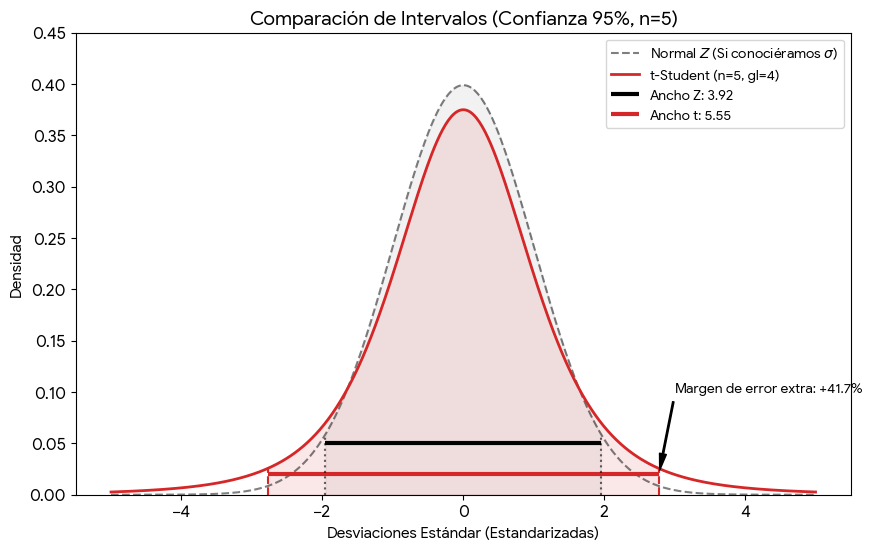

### Visualización de la diferencia ($Z$ vs $t$)

Para visualizar por qué es obligatorio usar la $t$-Student con muestras pequeñas cuando no conocemos $\sigma$, comparamos directamente el **Ancho del Intervalo** de ambas distribuciones.
Se puede observar que, para un mismo nivel de confianza (ej. 95%), el intervalo $t$ es mucho más ancho que el $Z$. Esto es el "castigo" por la incertidumbre de no conocer la verdadera desviación estándar poblacional.

#### Análisis de la diferencia
*   **El "Costo" de la ignorancia:** Para un $n=5$, el valor crítico de $Z$ es $\pm 1.96$, pero el de $t$ es $\pm 2.77$. Esto significa que el intervalo de confianza con $t$ es un **41% más ancho** que el de $Z$.
*   **Por qué usar $Z$ sería un error:** Si se usara $Z$ teniendo una muestra de solo 5 datos, se estaría reportando un margen de error mucho más pequeño del que realmente se tiene. Estaríamos diciendo que se tiene "mucha precisión" cuando en realidad los datos son insuficientes para asegurar tal cosa.
*   **Convergencia:** Si cambias $n$ a 100, se verá que las barras de "Ancho Z" y "Ancho t" casi se solapan.

### ¿Cuándo depende de la Desviación Estándar?
La elección sigue esta lógica estricta:
1. **¿Se conoce $\sigma$ (poblacional)?** $\rightarrow$ Siempre **$Z$**. (Caso raro en la vida real).
2. **¿No se conoce $\sigma$ y usas $s$ (muestral)?** $\rightarrow$ Siempre **$t$**.
    *   Si $n < 30$: El uso de $t$ es crítico (el error de usar $Z$ es enorme).
    *   Si $n \geq 30$: El uso de $t$ es correcto, pero usar $Z$ es una aproximación aceptable (el error es despreciable).

**✅ Concusión**
Se debe usar $t$ para $n$ pequeños porque la distribución $t$ compensa la incertidumbre adicional que se introduce al estimar la desviación estándar poblacional ($\sigma$) usando solo la desviación de la muestra ($s$). Si conociéramos $\sigma$ de antemano, podríamos usar $Z$ incluso con muestras de $n$.